# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"


# Enunciado

En esta actividad, el alumno debe **evaluar y comparar dos estrategias** para la **clasificación de imágenes** empleando el **dataset asignado**. El/La alumnx deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga el **pipeline visto en clase** para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

# Estrategia 1: Entrenar desde cero o *from scratch*

La primera estrategia a comparar será una **red neuronal profunda** que el **alumno debe diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que el alumno utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

## Carga de datos desde la plataforma Kaggle

In [ ]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 738.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77733 sha256=5bb2212dbf7fb43674bb93a45e48a552c13bebae16925b88824e048b3c783553
  Stored in directory: /root/.cache/pip/wheels/f3/16/ff/34e7d368370d4fd68bb749a59f1d2639ed66f3c14358e340a1
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


In [ ]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
# el archivo kaggle.json debe existir para que el script funcione
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Verificar si la conexión con kaggle fue existosa
!kaggle datasets list

ref                                                 title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023               Data Science Salaries 2023 💸                 25KB  2023-04-13 09:55:16           8033        207  1.0              
salvatorerastelli/spotify-and-youtube               Spotify and Youtube                           9MB  2023-03-20 15:43:25          12618        422  1.0              
iammustafatz/diabetes-prediction-dataset            Diabetes prediction dataset                 734KB  2023-04-08 06:11:45           4216         64  1.0              
shawkyelgendy/furniture-price-prediction            Furniture Price Prediction                   81KB  2023-04-17 09:35:17           1195         28  1.0       

In [ ]:
# descargar el data set
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.96G/1.96G [01:26<00:00, 24.4MB/s]
100% 1.96G/1.96G [01:26<00:00, 24.3MB/s]


In [ ]:
# Creemos un directorio para descomprimir los datos
!mkdir my_dataset

In [ ]:
# Descomprimimos los datos y los dejamos listos para trabajar
!unzip 100-bird-species.zip -d my_dataset

Streaming output truncated to the last 5000 lines.
  inflating: my_dataset/train/WHITE TAILED TROPIC/120.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/121.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/122.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/123.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/124.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/125.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/126.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/127.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/128.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/129.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/130.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/131.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/132.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/133.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC/134.jpg  
  inflating: my_dataset/train/WHITE TAILED TROPIC

In [ ]:
# Realizar la conexión con drive para guardar las épocas
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Escritura de datos tomando como referencia un BASE_FOLDER

In [ ]:
# La variable BASE_FOLDER tendrá el path donde se guardarán las épocas del entrenamiento
BASE_FOLDER = "/content/drive/MyDrive/07MIAR_Proyecto_Programacion/"
# Esta variable contiene el path con las imágenes en la instancia local del collab
# La carpeta se genera en el punto anterior
BASE_DATASET = 'my_dataset/'

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import itertools

# System libraries
from google.colab import drive
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
sns.set_style('darkgrid')

## Cargar datos

In [ ]:
# Leemos el archivo CSV llamado 'birds.csv' y lo cargamos en un Dataframe:
# * Este archivo hace parte del set de datos.
# La ruta del archivo se construye utilizando la variable 'BASE_DATASET'

df = pd.read_csv(f'{BASE_DATASET}birds.csv')

In [ ]:
# Una vez cargados los datos, creamos una nueva columna llamada 'filepaths' la cual
# utiliza una función lambda para concatenar el path de las imágenes a la ruta incluida
# en el achivo bird.csv.

image_df = df.copy()
image_df['filepaths'] = image_df['filepaths'].map(lambda x: BASE_DATASET + x)
image_df

,class id,filepaths,labels,data set,scientific name
0,0.0,my_dataset/train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
1,0.0,my_dataset/train/ABBOTTS BABBLER/007.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
2,0.0,my_dataset/train/ABBOTTS BABBLER/008.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
3,0.0,my_dataset/train/ABBOTTS BABBLER/009.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
4,0.0,my_dataset/train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train,MALACOCINCLA ABBOTTI
...,...,...,...,...,...
89880,524.0,my_dataset/valid/BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89881,524.0,my_dataset/valid/BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89882,524.0,my_dataset/valid/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524.0,my_dataset/valid/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


In [ ]:
# Se crean los queries para separa los data set de test, validación y entrenamiento
# df_test = datos para probar el modelo
# df_val = datos de validación durante el entrenamiento
# df_train = datos para entrenar el modelo

df_test = image_df[image_df['data set'] == 'test']
df_val = image_df[image_df['data set'] == 'valid']
df_train = image_df[image_df['data set'] == 'train']

## Explorar datos

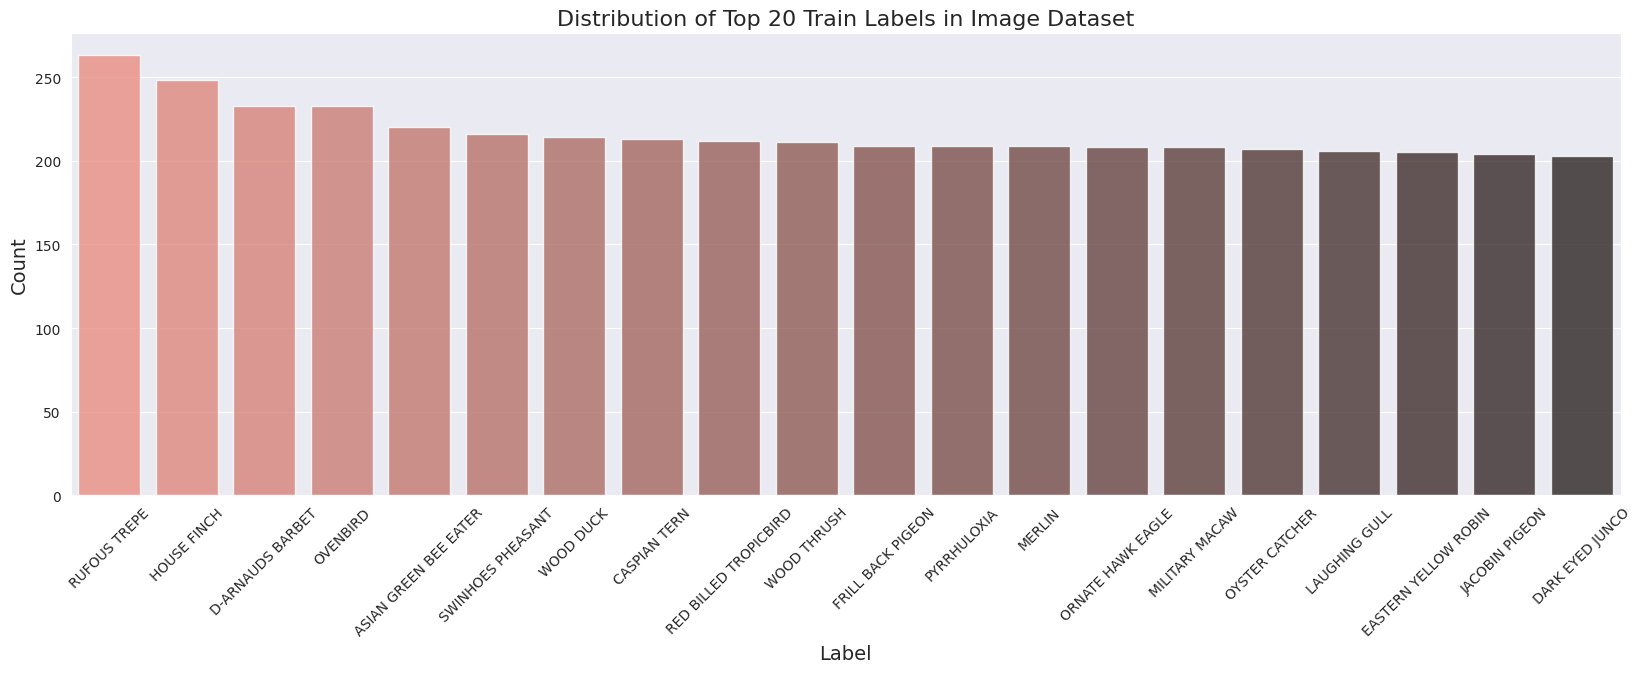

In [ ]:
# Generamos una visualización de la distribución de las 20 etiquetas 
# más comunes en el conjunto de entrenamiento ("df_train") del conjunto de datos de imágenes.

label_counts = df_train['labels'].value_counts()[:20]
plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Distribution of Top 20 Train Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Imprimimos en la consola el tamaño de los conjuntos de datos de prueba, validación y entrenamiento.

print('data def:')
print(df_test.shape)

print('data val:')
print(df_val.shape)

print('data train:')
print(df_train.shape)

data def:
(2625, 5)
data val:
(2625, 5)
data train:
(84635, 5)


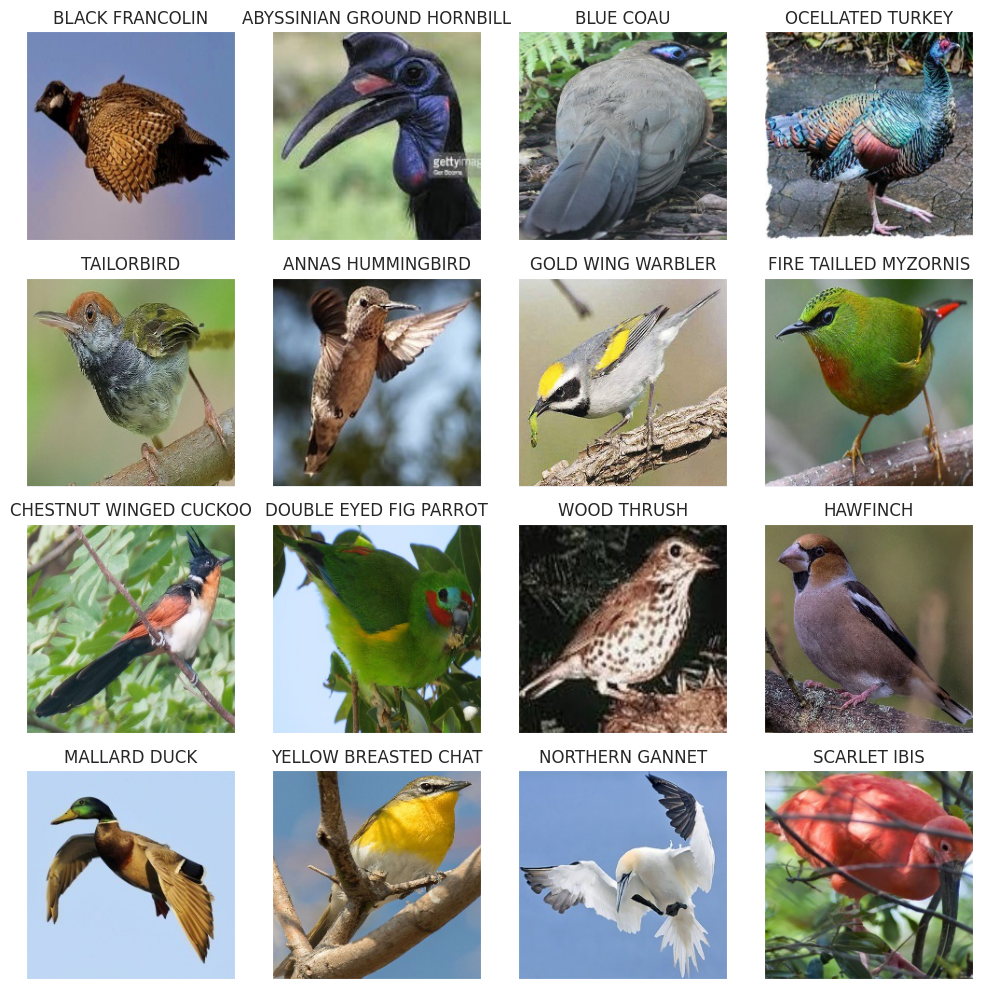

In [ ]:
# Como parte de la exploración de datos, mostramos 16 imagenes del Dataset con sus labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  series_img = df_train.sample()  
  img_path = series_img['filepaths'].iloc[0]
  ax.imshow(plt.imread(img_path))
  ax.set_title(series_img['labels'].iloc[0])
plt.tight_layout()
plt.show()

## Carga de imágenes en memoria

A continuación generamos la primera parte del pipeline para el entrenamiento del modelo. Esto incluye una capa de Data Agmentation utilizando la clase `ImageDataGenerator` disponible en la biblioteca keras.

Cabe destacar que para el entrenamiento de la red convolucional, se utilizó un `class_mode="spare"`, dato que será relevante a la hora de seleccionar el método para el cálculo de la pérdida.

Una vez ejecutadas el código, se evidencia un total de `84635` imagenes disponibles para el entrenamiento, y `2625` imagenes para el proceso de validación y pruebas. Esto es coherente con la información disponible en el archivo `birds.csv`.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Tamaño de las imagenes
SEED = 42
BATCH_SIZE = 32
TARGET_SIZE = (128, 128)

# Se define los path de los directorios TRAIN VALIDATION Y TEST
TRAIN_PATH = BASE_DATASET + '/train'
VAL_PATH   = BASE_DATASET + '/valid'
TEST_PATH  = BASE_DATASET + '/test'

# Generador de imagenes para entrenamiento     
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./ 255,
    zoom_range = 0.2,
    rotation_range = 5,
    horizontal_flip = True
)

train = train_datagen.flow_from_directory(
  TRAIN_PATH,
  seed=SEED,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode="sparse"
)

valid_datagen = ImageDataGenerator(rescale = 1. / 255)
valid = valid_datagen.flow_from_directory(
  VAL_PATH,
  seed=SEED,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode="sparse"
)

test_datagen = ImageDataGenerator(rescale = 1. / 255)
test = test_datagen.flow_from_directory(
    TEST_PATH,
    seed=SEED,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='sparse'
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


## Arquitectura de la CNN

La arquitectura seleccionada para esta red convolucional, corresponde a un encoder con dos bloques convolucionales. Cada bloque incluye una capa convolucional seguida de una capa de normalización. Al final del bloque se hace un max polloing y se desactiva el 50% de las neuronas durante cada paso de la etapa de entrenamiento.

El bloque final se encarga de la clasificación del modelo, realizando un aplanamiento de los datos y finalizando con una capa densa con los 525 clases que puede tomar una imágen de entrada.

In [ ]:
#########################################
###### Definimos la arquitectura ########
#########################################
from keras import regularizers

#BASE MODEL
# Definimos entradas
inputs = Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

# Primer set de capas CONV => RELU => CONV => RELU => POOL
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs) 
x1 = BatchNormalization()(x1) 
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(x1) 
x1 = BatchNormalization()(x1) 
x1 = MaxPooling2D(pool_size=(2, 2))(x1) 
x1 = Dropout(0.25)(x1) 

# Segundo set de capas CONV => RELU => CONV => RELU => POOL
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.25)(x2)

# TOP MODEL
# Primer (y único) set de capas FC => RELU
xfc = Flatten()(x2)
xfc = Dense(256, activation="relu")(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.5)(xfc)
# Clasificador softmax
predictions = Dense(525, activation="softmax")(xfc)

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs (Consultar la documentación)
model_cnn = Model(inputs=inputs, outputs=predictions)

Antes de compilar el modelo, es importante recordar que los datos fueron cargados utilizando el parámetro `class_mode="sparse"`, por lo tanto el parámetro `loss` del método `compile` debe tomar el valor `"sparse_categorical_crossentropy"`.

In [ ]:
model_cnn.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
  metrics=["accuracy"]
)

Finalmente, se muestra el resumen de la red utilizando el método `summary()`, en donde se puede evidenciar que el total de parámetros entrenables es de `16,979,757`. Un dato importante a mencionar, es que se hizo un reescalado de las imágenes de 224 a 128 con el objetivo de reducir el tiempo de entrenamiento.

In [ ]:
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0   

Con el objetivo de mejorar el entrenamiento, A continuación se definen una serie de callbacks para serán utilizados durante la fase de entrenamiento de la CNN. Los callbacks utilizados fueron:

1. **LearningRateScheduler**: Actualiza la tasa de aprendizaje del modelo en función del número de épocas a entrenar.
2. **ReduceLROnPlateau**: Reduce la tasa de aprendizaje del modelo si no mejora el `val_accuracy` durante el número de épocas a entrenar.
3. **EarlyStopping**: Detiene el entrenamiento si no mejora el `val_accuracy` durante un número determinado de épocas.
4. **ModelCheckpoint**: Guarda el module después de cada época si el `accuracy` que se optiene es mejor comparado con las iteraciones anteriores.

In [ ]:
from tensorflow.keras.models import load_model

# Save model after each epoch
checkpoint_path = "/content/drive/MyDrive/07MIAR/checkpoint-cnn-{epoch:02d}.h5"

lr_start   = 0.0012
lr_max     = 0.00015 * BATCH_SIZE
lr_min     = 1e-3
lr_ramp_ep = 3
lr_sus_ep  = 0
lr_decay   = 0.7
   
def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
            
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
    return lr

checkpoint_callback = [
  tf.keras.callbacks.LearningRateScheduler(lrfn),
  tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.2,
    patience = 2,
    mode = "auto",
    cooldown = 0,
    min_lr = 0.001,
  ),
  tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "auto",
  ),
  tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'auto',
    save_best_only = True
  )
]

## Entrenamiento de la CNN

El entrenamiento de la red convolucional utiliza los set de datos de entrenamiento y validación, y se definió un número de 20 épocas. Cada época duro más de 500s, con un total aproximado de 2.7 horas en total. El mejor accuracy obtenido durante la etapa de entrenamiento, fue durante la época 18, y puede ser descargada del siguiente enlace: https://drive.google.com/file/d/1-ZbwxylItRSDQGhvzaxs-zOZDGLFSwU0/view?usp=sharing

In [ ]:
# latest with 128, batch 32
epochs = 20

history = model_cnn.fit(
    train, 
    validation_data=valid, 
    epochs=epochs, 
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/20
2645/2645 [==============================] - 525s 193ms/step - loss: 4.7434 - accuracy: 0.1136 - val_loss: 3.2483 - val_accuracy: 0.3196 - lr: 0.0012
Epoch 2/20
2645/2645 [==============================] - 507s 192ms/step - loss: 3.3510 - accuracy: 0.2873 - val_loss: 3.0842 - val_accuracy: 0.3646 - lr: 0.0024
Epoch 3/20
2645/2645 [==============================] - 508s 192ms/step - loss: 2.8523 - accuracy: 0.3713 - val_loss: 2.6178 - val_accuracy: 0.4651 - lr: 0.0036
Epoch 4/20
2645/2645 [==============================] - 506s 191ms/step - loss: 2.5905 - accuracy: 0.4205 - val_loss: 2.2705 - val_accuracy: 0.5261 - lr: 0.0048
Epoch 5/20
2645/2645 [==============================] - 507s 192ms/step - loss: 2.2181 - accuracy: 0.4925 - val_loss: 1.6209 - val_accuracy: 0.6312 - lr: 0.0037
Epoch 6/20
2645/2645 [==============================] - 508s 192ms/step - loss: 1.9670 - accuracy: 0.5419 - val_loss: 1.9603 - val_accuracy: 0.5829 - lr: 0.0029
Epoch 7/20
2645/2645 [============

## Métricas

A continuación se grafica la evolución del entrenamiento y la validación de la red neuronal durante las 20 épocas de entrenamiento. 

Se utilizó la biblioteca Matplotlib para crear el gráfico. El gráfico incluye cuatro líneas: la pérdida de entrenamiento, la pérdida de validación, la precisión de entrenamiento y la precisión de validación.

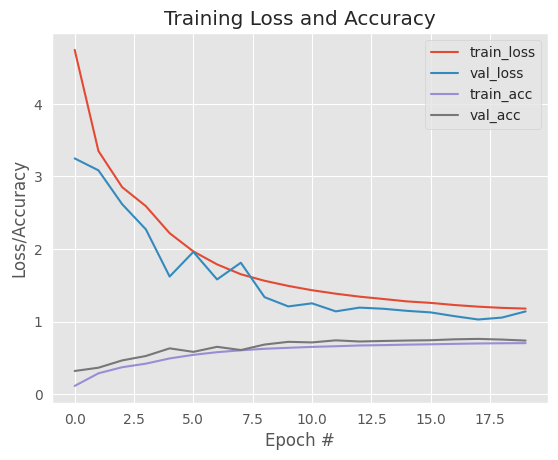

In [ ]:
l = len(history.history["loss"])
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, l), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, l), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, l), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, l), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
# Calculamos la pérdida y la precisión del modelo en el conjunto 
# de datos de prueba (test)

loss, Accuracy = model_cnn.evaluate(test)

83/83 [==============================] - 5s 60ms/step - loss: 1.0268 - accuracy: 0.7600


In [ ]:
# Hacemos predicciones sobre el conjunto de datos de prueba

predictions = model_cnn.predict(test, batch_size=BATCH_SIZE)
predicted_categories = np.argmax(predictions, axis=1)

83/83 [==============================] - 5s 53ms/step


In [ ]:
# Finalmente se muestra un reporte de clasificación para las imagenes de prueba

print(classification_report(df_test['class id'], predicted_categories))

              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.00      0.00      0.00         5
         2.0       0.67      0.40      0.50         5
         3.0       0.40      0.80      0.53         5
         4.0       0.83      1.00      0.91         5
         5.0       1.00      0.80      0.89         5
         6.0       1.00      1.00      1.00         5
         7.0       1.00      0.20      0.33         5
         8.0       1.00      1.00      1.00         5
         9.0       0.80      0.80      0.80         5
        10.0       1.00      0.40      0.57         5
        11.0       1.00      1.00      1.00         5
        12.0       0.00      0.00      0.00         5
        13.0       1.00      0.20      0.33         5
        14.0       1.00      0.80      0.89         5
        15.0       1.00      0.60      0.75         5
        16.0       0.57      0.80      0.67         5
        17.0       0.71    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Para concluir, el modelo se entrenó durante más de 2 horas y media, y logró una buena precisión del `76.15%` utilizando los datos de validación y `76%` utilizando los datos de prueba. Estos resultados demuestran que el modelo tiene una buena capacidad para generalización a la hora de categorizar imagenes desconocidas, sin embargo, el tiempo requerido para alcanzar niveles altos de precisión es elevado.

# Estrategia 2: Red pre-entrenada

La segunda estrategia a comparar debe incluir la utilización de una **red preentrenada** con el dataset ImageNet, llevando a cabo tareas de ***transfer learning*** y ***fine-tuning*** para resolver la tarea de clasificación asignada. Deben **compararse al menos dos tipos de arquitecturas** (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe **seleccionar la que mayor precisión proporcione** (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera que el/la alumnx utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

## Contexto

Para realizar la comparación del segundo punto, se seleccionaron las redes MobileNetV2 y DenseNet201.

### MobileNetV2

#### Carga de datos para: MobileNetV2

Para realiar el aprendizaje por refuerzo, los datos fueron cargados utilizando  One-Hot-Encoding, esto se realiza al configurar el parámetro `class_mode` con un valor de `'categorical'`.

In [ ]:

BASE_DATASET = 'my_dataset/'

# Tamaño de las imagenes
SEED = 42
BATCH_SIZE = 32
TARGET_SIZE = (128, 128)

# Se define los path de los directorios TRAIN VALIDATION Y TEST
TRAIN_PATH = BASE_DATASET + '/train'
VAL_PATH   = BASE_DATASET + '/valid'
TEST_PATH  = BASE_DATASET + '/test'

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,  
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)  

validation_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


#### Arquitectura de la red: MobileNetV2

Para la creación de la arquitectura, primero importamos de red MobileNetV2 disponible en la biblioteca Keras y la asignamos a la variable base_model. 

La instancia del modelo incluye: 
1. El parámetro `include_top` con un valor de  `False` para indicar que se excluya la capa fully-connected (FC) en la parte superior de la red. 
2. El parámetro, `weights` con un valor de `"imagenet"` para indicar que se carguen los pesos pre-entrenados en el conjunto de datos `ImageNet`. 
3. El parámetro `input_shape` con un valor de `(TARGET_SIZE[0], TARGET_SIZE[1], 3)` que especifica la forma de los datos de entrada.  El valor `3` en la tupla se utiliza para indicar que que los datos de entrada son en 3 dimensiones, en este caso imágenes a color RGB.

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top = False, # Indica si se incluye o no la capa completamente conectada en la parte superior de la red
    weights = 'imagenet', # Pesos pre-entrenados utilizados para inicializar el modelo
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3) # Tamaño de entrada de las imágenes
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary() # muestra información sobre las capas, sus formas de salida y el número total de parámetros entrenables

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

Para este ejercicio, se congelaron todas las capas del modelo base, sin embargo, es posible congelar alguno de los layers de la siguiente manera:
```
# Obtener el número de capas del modelo base
num_layers = len(base_model.layers)

# Ej: congelar la mitad de las capas
for layer in base_model.layers[:num_layers//2]:
    layer.trainable = False
```

In [ ]:
# Deshabilitar el entrenamiento del modelo base
base_model.trainable = False

number of layers: 154


In [ ]:
from tensorflow.keras.models import load_model

# Ruta para guardar el modelo después de cada época
checkpoint_path = "/content/drive/MyDrive/07MIAR/checkpoint-MobileNetV2-{epoch:02d}.h5"


checkpoint_callback = [
  # Callback para reducir la tasa de aprendizaje cuando la métrica de validación se estanca
  tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.2,
    patience = 2,
    mode = "auto",
    cooldown = 0,
    min_lr = 0.001,
  ),
  # Callback para detener el entrenamiento si la métrica de validación deja de mejorar
  tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "auto",
  ),
  # Callback para guardar el mejor modelo durante el entrenamiento
  tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'auto',
    save_best_only = True
  )
]

A continuación se utiliza el API secuencial para crear la arquitectura de la red. El modelo cuenta con un "top modelling" que incluye una capa de aplanamiento, seguida de una capa densa con 256 neuronas y una normalización. Además se incluyó una capa de Dropout para desahabilitar el 50% de las neuronas en cada paso. La última capa de salida cuenta con 525 neuronas que se activaran para diferenciar los valores de las clases incluidas en el set datos.

In [ ]:
inputs = Input(shape =(TARGET_SIZE[0], TARGET_SIZE[1], 3), name = "input-layer")

x = base_model(inputs)

# TOP model:
xfc = Flatten()(x) # Capa de aplanamiento
xfc = Dense(256, activation="relu")(xfc) # Capa densa con activación ReLU
xfc = BatchNormalization()(xfc) # Capa de normalización
xfc = Dropout(0.5)(xfc) # Capa de regularización Dropout
predictions = Dense(525, activation="softmax")(xfc) # Capa de salida con activación softmax para la clasificación

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs (Consultar la documentación)
model_MobileNetV2 = Model(inputs=inputs, outputs=predictions) #(X)
model_MobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0     

Para compilar el modelo, se utilizo una perdida de tipo `categorical_crossentropy`, debido a que las imágenes fueron cargadas utilizando one-hot-encoding. Adicional se utilizó un learning rate de `0.0001` el cual produjo los mejores resultados a la hora de entrenar la red convolucional del punto 1.

In [ ]:
from tensorflow.keras.optimizers import Adam

model_MobileNetV2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Entrenamiento: MobileNetV2

El entrenamiento se corrió por solo 10 épocas, la mitad de las épocas utilizadas para entrenar la red convolucional entrenada en el primer punto. Adicional, en los callbacks no se utilizó un `learning rate scheduler`, en su lugar, se utilizó "learning rate" que dio mejores resultados en el primer punto.

In [ ]:
history = model_MobileNetV2.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
2645/2645 [==============================] - 497s 183ms/step - loss: 4.5922 - accuracy: 0.1863 - val_loss: 2.6458 - val_accuracy: 0.5733 - lr: 1.0000e-04
Epoch 2/10
2645/2645 [==============================] - 473s 179ms/step - loss: 2.9027 - accuracy: 0.4247 - val_loss: 1.6332 - val_accuracy: 0.7067 - lr: 1.0000e-04
Epoch 3/10
2645/2645 [==============================] - 467s 176ms/step - loss: 2.2480 - accuracy: 0.5214 - val_loss: 1.2147 - val_accuracy: 0.7566 - lr: 1.0000e-04
Epoch 4/10
2645/2645 [==============================] - 460s 174ms/step - loss: 1.9212 - accuracy: 0.5715 - val_loss: 1.0072 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 5/10
2645/2645 [==============================] - 466s 176ms/step - loss: 1.7444 - accuracy: 0.5995 - val_loss: 0.9087 - val_accuracy: 0.7947 - lr: 1.0000e-04
Epoch 6/10
2645/2645 [==============================] - 460s 174ms/step - loss: 1.6160 - accuracy: 0.6197 - val_loss: 0.8478 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 7/10

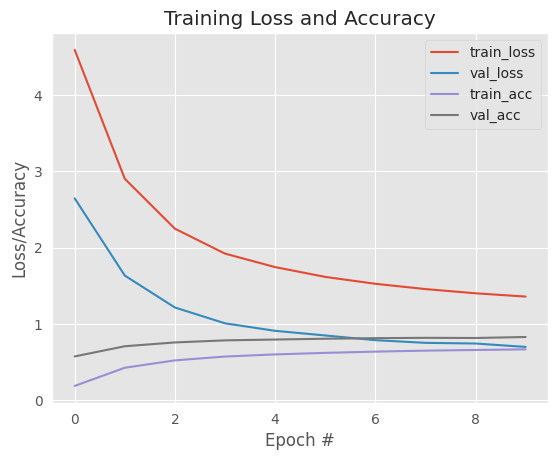

In [ ]:
l = len(history.history["loss"])
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, l), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, l), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, l), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, l), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
loss, Accuracy = model_MobileNetV2.evaluate(test_generator)
print(f'real loss: {loss}, real accuracy: {Accuracy}')

83/83 [==============================] - 6s 76ms/step - loss: 0.6086 - accuracy: 0.8533
real loss: 0.6086471676826477, real accuracy: 0.8533333539962769


In [ ]:
predictions = model_MobileNetV2.predict(test_generator, batch_size=BATCH_SIZE)
predicted_categories = np.argmax(predictions, axis=1)

83/83 [==============================] - 7s 73ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_test['class id'], predicted_categories))

              precision    recall  f1-score   support

         0.0       0.50      0.20      0.29         5
         1.0       0.80      0.80      0.80         5
         2.0       1.00      1.00      1.00         5
         3.0       1.00      0.80      0.89         5
         4.0       1.00      1.00      1.00         5
         5.0       1.00      1.00      1.00         5
         6.0       1.00      1.00      1.00         5
         7.0       1.00      0.80      0.89         5
         8.0       1.00      1.00      1.00         5
         9.0       0.83      1.00      0.91         5
        10.0       0.67      0.80      0.73         5
        11.0       1.00      1.00      1.00         5
        12.0       0.40      0.40      0.40         5
        13.0       1.00      0.20      0.33         5
        14.0       1.00      1.00      1.00         5
        15.0       0.83      1.00      0.91         5
        16.0       0.83      1.00      0.91         5
        17.0       0.83    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Conclusiones: MobileNetV2

Con los valores de prueba se obtuvo una una de pérdida de `69.79%` y una presición de `82.78`. Al evaluar el modelo sobre los datos de prueba, se obtuvo una perdida de `60.86%` y una precisión de `85.33%`. Se puede ver como el modelo pudo obtener una mejor precisión, en menos épocas y con un tiempo de entrenamiento menor si lo comparamos con la red convolucional que se entrenón en el primer punto.

### DenseNet201

Para el entrenamiento de la siguiente red, se repitieron los pasos del punto anterior.

#### Carga de datos: DenseNet201

In [ ]:
BASE_DATASET = 'my_dataset/'

# Tamaño de las imagenes
SEED = 42
BATCH_SIZE = 28
TARGET_SIZE = (112, 112)

# Se define los path de los directorios TRAIN VALIDATION Y TEST
TRAIN_PATH = BASE_DATASET + '/train'
VAL_PATH   = BASE_DATASET + '/valid'
TEST_PATH  = BASE_DATASET + '/test'

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,  
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)  

validation_generator = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


#### Arquitectura de la red: DenseNet201

In [ ]:
from tensorflow.keras.applications import DenseNet201

base_model = DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
)

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 118, 118, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 56, 56, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 56, 56, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
num_layers = len(base_model.layers)
print(f'number of layers: {num_layers}')

# Freeze the first half of the layers
for layer in base_model.layers[:num_layers//2]:
    layer.trainable = False

base_model.trainable = False

number of layers: 707


In [ ]:
from tensorflow.keras.models import load_model

# Save model after each epoch
checkpoint_path = "/content/drive/MyDrive/07MIAR/checkpoint-DenseNet201-{epoch:02d}.h5"

checkpoint_callback = [
  tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.2,
    patience = 2,
    mode = "auto",
    cooldown = 0,
    min_lr = 0.001,
  ),
  tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    patience = 5,
    verbose = 1,
    mode = "auto",
  ),
  tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'auto',
    save_best_only = True
  )
]

In [ ]:
inputs = Input(shape =(TARGET_SIZE[0], TARGET_SIZE[1], 3), name = "input-layer")

x = base_model(inputs)
xfc = Flatten()(x) #(X)
xfc = Dense(256, activation="relu")(xfc) #(X)
xfc = BatchNormalization()(xfc) #(X)
xfc = Dropout(0.5)(xfc) #(X)
# Clasificador softmax
predictions = Dense(525, activation="softmax")(xfc) #(X)

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs (Consultar la documentación)
model_DenseNet201 = Model(inputs=inputs, outputs=predictions) #(X)
model_DenseNet201.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-layer (InputLayer)    [(None, 112, 112, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 17280)             0         
                                                                 
 dense (Dense)               (None, 256)               4423936   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [ ]:
from tensorflow.keras.optimizers import Adam

model_DenseNet201.compile(
    optimizer=Adam(learning_rate=0.00012),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### Entrenamiento: DenseNet201

In [ ]:
history = model_DenseNet201.fit(
    train_generator, 
    validation_data=validation_generator,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
3023/3023 [==============================] - 467s 154ms/step - loss: 4.2206 - accuracy: 0.2398 - val_loss: 2.1212 - val_accuracy: 0.6560 - lr: 1.2000e-04
Epoch 2/10
3023/3023 [==============================] - 452s 150ms/step - loss: 2.6416 - accuracy: 0.4656 - val_loss: 1.2696 - val_accuracy: 0.7630 - lr: 1.2000e-04
Epoch 3/10
3023/3023 [==============================] - 449s 148ms/step - loss: 2.0788 - accuracy: 0.5452 - val_loss: 0.9616 - val_accuracy: 0.7897 - lr: 1.2000e-04
Epoch 4/10
3023/3023 [==============================] - 443s 147ms/step - loss: 1.8249 - accuracy: 0.5824 - val_loss: 0.8290 - val_accuracy: 0.8069 - lr: 1.2000e-04
Epoch 5/10
3023/3023 [==============================] - 441s 146ms/step - loss: 1.6732 - accuracy: 0.6074 - val_loss: 0.7309 - val_accuracy: 0.8267 - lr: 1.2000e-04
Epoch 6/10
3023/3023 [==============================] - 440s 145ms/step - loss: 1.5715 - accuracy: 0.6266 - val_loss: 0.7205 - val_accuracy: 0.8206 - lr: 1.2000e-04
Epoch 7/10

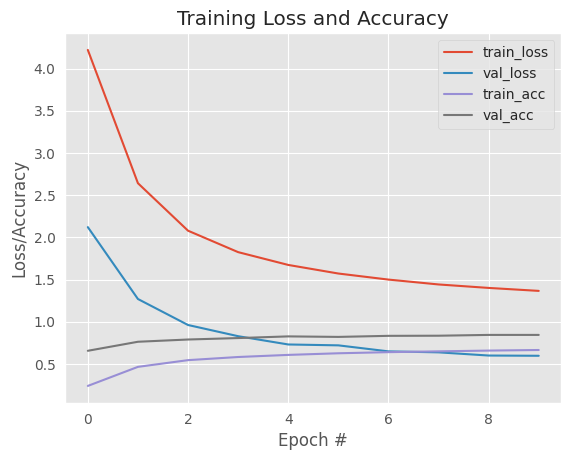

In [ ]:
l = len(history.history["loss"])
# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, l), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, l), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, l), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, l), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
loss, Accuracy = model_DenseNet201.evaluate(test_generator)
print(f'real loss: {loss}, real accuracy: {Accuracy}')

94/94 [==============================] - 8s 89ms/step - loss: 0.4662 - accuracy: 0.8762
real loss: 0.46615225076675415, real accuracy: 0.8761904835700989


In [ ]:
predictions = model_DenseNet201.predict(test_generator, batch_size=BATCH_SIZE)
predicted_categories = np.argmax(predictions, axis=1)

94/94 [==============================] - 9s 67ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_test['class id'], predicted_categories))

              precision    recall  f1-score   support

         0.0       1.00      0.40      0.57         5
         1.0       1.00      0.40      0.57         5
         2.0       1.00      1.00      1.00         5
         3.0       0.71      1.00      0.83         5
         4.0       1.00      0.80      0.89         5
         5.0       0.67      0.80      0.73         5
         6.0       1.00      1.00      1.00         5
         7.0       1.00      0.80      0.89         5
         8.0       0.80      0.80      0.80         5
         9.0       0.80      0.80      0.80         5
        10.0       1.00      0.60      0.75         5
        11.0       1.00      1.00      1.00         5
        12.0       0.83      1.00      0.91         5
        13.0       1.00      0.40      0.57         5
        14.0       1.00      1.00      1.00         5
        15.0       1.00      0.80      0.89         5
        16.0       0.83      1.00      0.91         5
        17.0       0.80    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Conclusiones: DenseNet201

Con los valores de prueba se obtuvo una una de pérdida de `59.69%` y una presición de `84.42`. Al evaluar el modelo sobre los datos de prueba, se obtuvo una perdida de `46.61%` y una precisión de `87.61%`. Se puede ver como el modelo pudo obtener una mejor precisión, en menos épocas y con un tiempo de entrenamiento menor si lo comparamos con la red convolucional que se entrenón en el primer punto.


# Comparación de las soluciones

En la siguiente gráfica se puede ver un resumen de las métricas de los tres modelos entrenados:

\begin{array}{|l|c|c|} \hline
Modelo & accuracy & loss \\ \hline
CNN & 76.00 & 1.0268 \\
MobileNetV2 & 85.33 & 60.86 \\
DenseNet201 & 87.61 & 46.61 \\ \hline
\end{array}

De la tabla inferir que los mejores resultados se obtuvieron al entrenar una red con un modelo base que implemente la arquitectura `DenseNet201`. Este modelo presentó las menores pérdidas y la mayor precisión. 


A partir de estos resultados, se puede inferir que el modelo basado en la arquitectura `DenseNet201` fue el que demostró un rendimiento superior en comparación con el modelo que utiliza una red convolucional y el que utiliza la red `MobileNetV2`. 

La red neuronal `DenseNet201` tuvo tanto las pérdidas más bajas como la precisión más alta en la clasificación de las imágenes. Esto nos permite concluir, que la arquitectura `DenseNet201` es la mejor opción para abordar este problema de clasificación de pajaros.